# Location Bias
##### from 60352 instances to 24120

In [66]:
import boto3
import sagemaker
import pandas as pd

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

### upload the finalcsv file from s3 for bias analysis
##### this is the file the athena file was created from

In [67]:
!aws s3 cp 's3://sagemaker-us-east-1-418795740224/athena/files/final.csv' ./

download: s3://sagemaker-us-east-1-418795740224/athena/files/final.csv to ./final.csv


### Load csv into dataframe

In [68]:
df = pd.read_csv("final.csv")

### Visualize

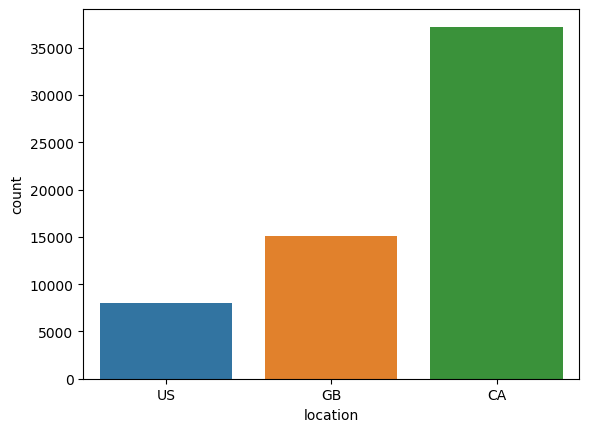

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

x = sns.countplot(data=df, x="location")#x="category", hue="location")
plt.show(x)

In [106]:
df_grouped_by = df.groupby(["location"])
df_balanced = df_grouped_by.apply(lambda x: x.sample(df_grouped_by.size().min()).reset_index(drop=True))
df_balanced.shape

(24120, 15)

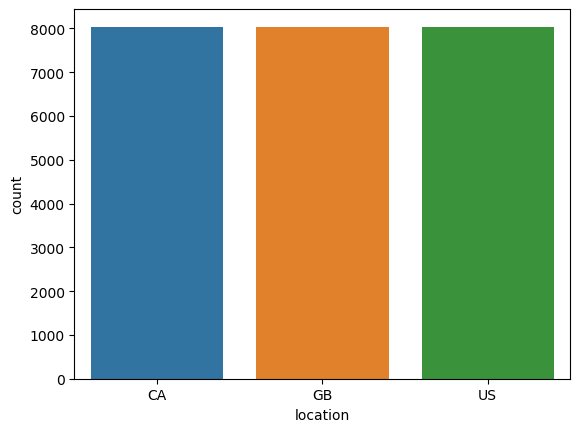

In [107]:
x = sns.countplot(data=df_balanced, x="location")
plt.show(x)

### Save in current directory

In [108]:
path_balanced = "./final_balanced.csv"
df_balanced.to_csv(path_balanced, index=False, header=True)

### Save in s3 bucket

In [110]:
path_balanced = "s3://{}/balanced.csv".format(bucket)
df_balanced.to_csv(path_balanced, index=False, header=True)

# Run Data Bias Analysis with SageMaker Clarify (Pre-Training)

In [111]:
import boto3
import sagemaker
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

### SageMaker Clarify helps you detect possible pre- and post-training biases using a variety of metrics.

In [112]:
from sagemaker import clarify

clarify_processor = clarify.SageMakerClarifyProcessor(
    role=role, 
    instance_count=1, 
    instance_type="ml.c5.xlarge", 
    sagemaker_session=sess
)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: 1.0.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


In [113]:
bias_report_output_path = "s3://{}/clarify".format(bucket)

bias_data_config = clarify.DataConfig(
    s3_data_input_path='final_balanced.csv',
    s3_output_path=bias_report_output_path,
    label="location",
    headers=df_balanced.columns.to_list(),
    dataset_type="text/csv",
)

In [114]:
bias_config = clarify.BiasConfig(label_values_or_threshold=["CA"], facet_name="view_count",facet_values_or_threshold=[1500000],)

In [115]:
clarify_processor.run_pre_training_bias(
    data_config=bias_data_config, 
    data_bias_config=bias_config, 
    methods=["CI", "DPL", "KL", "JS", "LP", "TVD", "KS"],
    wait=False, 
    logs=False
)

INFO:sagemaker.clarify:Analysis Config: {'dataset_type': 'text/csv', 'headers': ['location', 'title', 'channelTitle', 'tags', 'view_count', 'likes', 'dislikes', 'comment_count', 'comments_disabled', 'ratings_disabled', 'description_length', 'timepublished', 'trending_month', 'trending_year', 'category'], 'label': 'location', 'label_values_or_threshold': ['CA'], 'facet': [{'name_or_index': 'view_count', 'value_or_threshold': [1500000]}], 'methods': {'report': {'name': 'report', 'title': 'Analysis Report'}, 'pre_training_bias': {'methods': ['CI', 'DPL', 'KL', 'JS', 'LP', 'TVD', 'KS']}}}
INFO:sagemaker:Creating processing-job with name Clarify-Pretraining-Bias-2023-04-11-07-02-27-751


In [116]:
run_pre_training_bias_processing_job_name = clarify_processor.latest_job.job_name
run_pre_training_bias_processing_job_name

'Clarify-Pretraining-Bias-2023-04-11-07-02-27-751'

In [119]:
running_processor = sagemaker.processing.ProcessingJob.from_processing_name(
    processing_job_name=run_pre_training_bias_processing_job_name, sagemaker_session=sess
)

processing_job_description = running_processor.describe()
running_processor.wait(logs=False)

{'ProcessingInputs': [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-418795740224/Clarify-Pretraining-Bias-2023-04-11-07-02-27-751/input/dataset/final_balanced.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-418795740224/clarify/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}], 'ProcessingOutputConfig': {'Outputs': [{'OutputName': 'analysis_result', 'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-418795740224/clarify', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}, 'AppManaged': False}]}, 'ProcessingJobName': 'Clarify-Pretraining-Bias-2023-04-11-0

### View files in output location

In [121]:
!aws s3 ls $bias_report_output_path/

2023-04-11 07:08:11       1968 analysis.json
2023-04-11 07:02:28        551 analysis_config.json
2023-04-11 07:08:12     526542 report.html
2023-04-11 07:08:12     254676 report.ipynb
2023-04-11 07:08:11     259681 report.pdf


### Save into new folder in directory

In [122]:
#!aws s3 cp --recursive $bias_report_output_path ./generated_bias_report/

download: s3://sagemaker-us-east-1-418795740224/clarify/analysis_config.json to generated_bias_report/analysis_config.json
download: s3://sagemaker-us-east-1-418795740224/clarify/analysis.json to generated_bias_report/analysis.json
download: s3://sagemaker-us-east-1-418795740224/clarify/report.ipynb to generated_bias_report/report.ipynb
download: s3://sagemaker-us-east-1-418795740224/clarify/report.pdf to generated_bias_report/report.pdf
download: s3://sagemaker-us-east-1-418795740224/clarify/report.html to generated_bias_report/report.html
